In [1]:
import sys
sys.path.append("D:/Yuichi/MemoryAge_Transformer_xLARGE")
# the code needs to search for the modules in the parent directory

from torcheeg import transforms
from torcheeg.datasets import MemoryAgeDataset
from torcheeg.model_selection import KFoldCrossSubject
from torcheeg.models import LFP_Transformer_LARGE
from torcheeg.trainers import ClassifierTrainer
import torch
from torch.utils.data.dataloader import DataLoader

import os
import multiprocessing
CPU_num = multiprocessing.cpu_count()

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl

from scipy.signal import welch
from tqdm import tqdm

In [2]:
mice = ['ym212', 'ym213', 'ym214', 'ym215', 'ym218', 'ym219', 'ym220', 'ym222', 'ym223', 'ym224', 'ym226', 'ym227']

feature_names = ['ACC_theta', 'CA1_theta', 'BLA_theta', 
                 'ACC_beta', 'CA1_beta', 'BLA_beta', 
                 'ACC_sGamma', 'CA1_sGamma', 'BLA_sGamma',
                 'ACC_fGamma', 'CA1_fGamma', 'BLA_fGamma']

channel_map = {'ACC': 0, 'CA1': 1, 'BLA': 2}
freq_map = {'theta': (6,12), 'beta': (20,30), 'sGamma': (30,50), 'fGamma': (60,90)}

fs = 1600

# 1. perturbation analysis

In [3]:
test_pertur_f1_all = np.load('./processed_dataset/perturbation_samples/results/test_pertur_f1_all.npy', allow_pickle=True)
best_f1_scores_all = np.load('./processed_dataset/perturbation_samples/results/best_f1_scores_all.npy', allow_pickle=True)

In [4]:
test_pertur_f1_all_dict = {feature: np.array([]) for feature in feature_names}
for feature in feature_names:
    test_pertur_f1_all_dict[feature] = np.array([tmp.item() for tmp in test_pertur_f1_all.item()[feature]])
    test_pertur_f1_all_dict[feature] = best_f1_scores_all - test_pertur_f1_all_dict[feature]
    

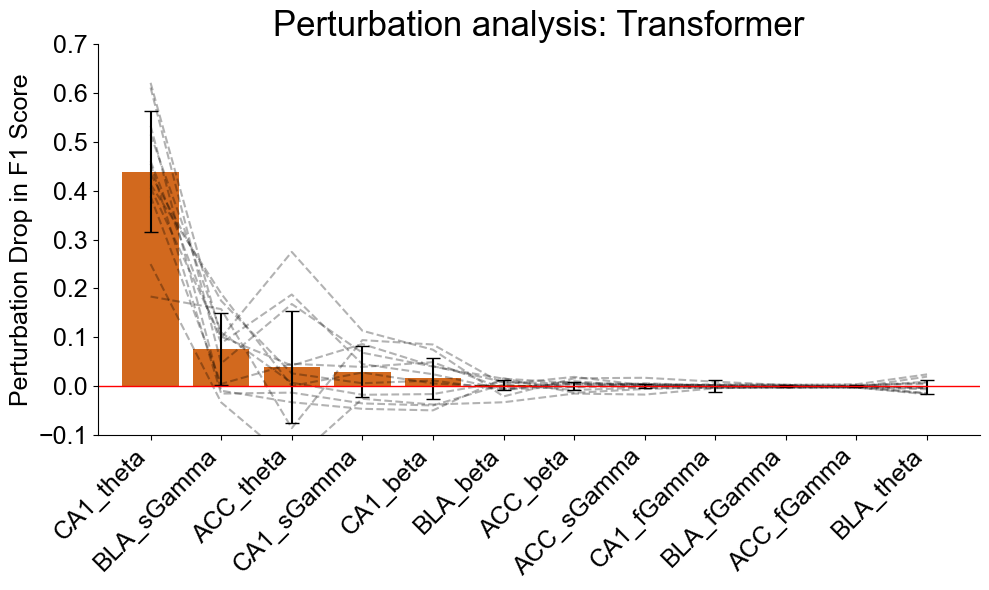

In [5]:
# Filtering and calculating averages and standard deviations again
filtered_data = {k: (np.mean(v), np.std(v)) for k, v in test_pertur_f1_all_dict.items()}
sorted_data = sorted(filtered_data.items(), key=lambda x: x[1][0], reverse=True)

# Preparing data for plotting again
features, values = zip(*sorted_data)
means, stds = zip(*values)

# Plotting with light blue bars
plt.figure(figsize=(10, 6))
bars = plt.bar(features, means, yerr=stds, capsize=5, color='chocolate')

# # Adding individual data points
# for i, feature in enumerate(features):
#     y_values = test_pertur_f1_all_dict[feature]
#     x_values = [bars[i].get_x() + bars[i].get_width() / 2] * len(y_values)
#     plt.scatter(x_values, y_values, marker='o', color='black')

#
test_pertur_f1_all_dict_df = pd.DataFrame(test_pertur_f1_all_dict)
# rearrange the order of columns in this order
test_pertur_f1_all_dict_df = test_pertur_f1_all_dict_df[['CA1_theta', 'BLA_sGamma', 'ACC_theta', 'CA1_sGamma', 'CA1_beta', 'BLA_theta',
                                                         'BLA_beta', 'ACC_beta', 'ACC_sGamma', 'BLA_fGamma', 'ACC_fGamma', 'CA1_fGamma']]

# connect the dots of each row of test_pertur_f1_all_dict_df using lines
for i in range(test_pertur_f1_all_dict_df.shape[0]):
    plt.plot(np.arange(0, 12), test_pertur_f1_all_dict_df.iloc[i], color='black', linestyle='--', alpha=0.3)

plt.ylabel('Perturbation Drop in F1 Score', font='Arial', fontsize=18)
plt.ylim(-0.1, 0.7)
plt.xlim(-0.75, 11.75)
plt.xticks(rotation=45,  ha='right', font='Arial', fontsize=18)
plt.yticks(font='Arial', fontsize=18)
# plot a horizontal line at 0
plt.axhline(y=0, color='r', linewidth=1)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Perturbation analysis: Transformer', font='Arial', fontsize=25)

plt.tight_layout()
plt.show()


In [6]:
TH = 0

In [7]:
from scipy import stats

wilcoxon_results = {}
# do a One-Sample Wilcoxon Signed-Rank Test of each feature in feature_imp_all_values against 0.085
for feature in features:
    stat, p_value = stats.wilcoxon(np.array(test_pertur_f1_all_dict[feature]) - TH, alternative="greater")
    wilcoxon_results[feature] = {"statistic": stat, "p_value": p_value}

wilcoxon_results

{'CA1_theta': {'statistic': 78.0, 'p_value': 0.000244140625},
 'BLA_sGamma': {'statistic': 69.0, 'p_value': 0.008056640625},
 'ACC_theta': {'statistic': 53.0, 'p_value': 0.150634765625},
 'CA1_sGamma': {'statistic': 60.0, 'p_value': 0.054931640625},
 'CA1_beta': {'statistic': 54.0, 'p_value': 0.133056640625},
 'BLA_beta': {'statistic': 49.0, 'p_value': 0.23486328125},
 'ACC_beta': {'statistic': 45.0, 'p_value': 0.338623046875},
 'ACC_sGamma': {'statistic': 37.5, 'p_value': 0.574951171875},
 'CA1_fGamma': {'statistic': 40.0, 'p_value': 0.48486328125},
 'BLA_fGamma': {'statistic': 29.0, 'p_value': 0.7880859375},
 'ACC_fGamma': {'statistic': 26.0, 'p_value': 0.849365234375},
 'BLA_theta': {'statistic': 39.0, 'p_value': 0.51513671875}}

In [8]:
test_pertur_f1_all_dict_df.to_csv('Transformer_Perturbation_Analysis.csv', index=False)